In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

#step 1

                                                text sentiment  label
0  im feeling rather rotten so im not very ambiti...   Sadness      0
1          im updating my blog because i feel shitty   Sadness      0
2  i never make her separate from me because i do...   Sadness      0
3  i left with my bouquet of red and yellow tulip...       Joy      1
4    i was feeling a little vain when i did this one   Sadness      0


Class distribution: Counter({'Joy': 695, 'Sadness': 581, 'Anger': 275, 'Fear': 224, 'Love': 159, 'Surprised': 66})




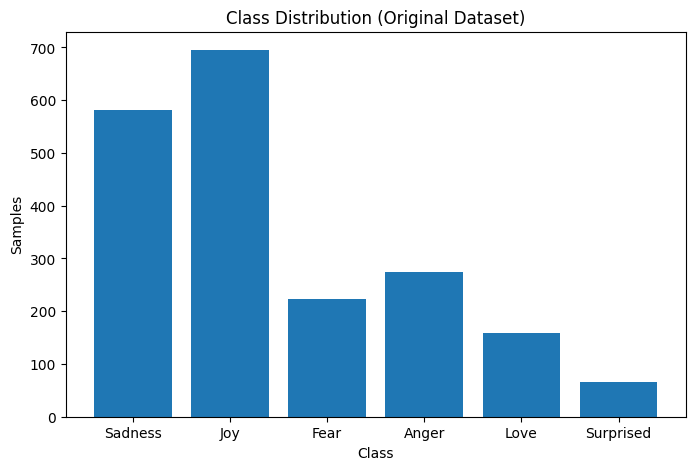



Class distribution: Counter({np.int64(1): 695, np.int64(0): 581, np.int64(3): 275, np.int64(4): 224, np.int64(2): 159, np.int64(5): 66})


In [7]:

# Load dataset
df = pd.read_csv("test.csv")

# count each label
print(df.head())
print("\n")
texts = df["text"].values
sentiments = df["sentiment"].values
labels = df["label"].values


print("Class distribution:", Counter(sentiments))

print("\n")
# visualize the imbalanced dataset
counts = Counter(label for label in df['sentiment'])
plt.figure(figsize=(8,5))
plt.bar(counts.keys(), counts.values())
plt.xlabel("Class")
plt.ylabel("Samples")
plt.title("Class Distribution (Original Dataset)")
plt.show()

print("\n")
print("Class distribution:", Counter(labels))



In [ ]:
#some preprocessing (TD-IDF)

vectorizer = TfidfVectorizer(max_features=3000, stop_words="english")
X = vectorizer.fit_transform(texts).toarray()
y = labels

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

minority_class = min(Counter(y_train), key=Counter(y_train).get)
majority_count = max(Counter(y_train).values())

X_minority = X_train[y_train == minority_class]
input_dim = X.shape[1]

print("Minority samples shape:", X_minority.shape)

Minority samples shape: (53, 3000)


#step 2: GAN Implementation


- vanilla GAN


In [ ]:
class Generator(nn.Module):
    def __init__(self, z_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim)
        )
    def forward(self, z):
        return self.net(z)

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
z_dim = 100
G = Generator(z_dim, input_dim).to(device)
D = Discriminator(input_dim).to(device)

criterion = nn.BCELoss()
opt_G = optim.Adam(G.parameters(), lr=0.0002)
opt_D = optim.Adam(D.parameters(), lr=0.0002)

X_min_tensor = torch.tensor(X_minority, dtype=torch.float32).to(device)

epochs = 5000
for epoch in range(epochs):
    idx = np.random.randint(0, X_min_tensor.size(0), 32)
    real = X_min_tensor[idx]

    z = torch.randn(32, z_dim).to(device)
    fake = G(z)

    D_loss = criterion(D(real), torch.ones(32,1).to(device)) + \
             criterion(D(fake.detach()), torch.zeros(32,1).to(device))
    opt_D.zero_grad(); D_loss.backward(); opt_D.step()

    G_loss = criterion(D(fake), torch.ones(32,1).to(device))
    opt_G.zero_grad(); G_loss.backward(); opt_G.step()

# Generate Vanilla GAN samples
    num_gen = majority_count - len(X_minority)
    z = torch.randn(num_gen, z_dim).to(device)
    X_vanilla = G(z).detach().cpu().numpy()
    y_vanilla = np.full(num_gen, minority_class)

    X_train_vanilla = np.vstack([X_train, X_vanilla])
    y_train_vanilla = np.concatenate([y_train, y_vanilla])

    if epoch % 500 == 0:
            print(f"Epoch [{epoch}/{epochs}] Loss D: {D_loss.item():.4f}, Loss G: {G_loss.item():.4f}")

print("\n--- Vanilla GAN Generated Sample Statistics ---")
print(f"X_vanilla shape: {X_vanilla.shape}")
print(f"X_vanilla min: {X_vanilla.min()}, max: {X_vanilla.max()}, mean: {X_vanilla.mean()}, std: {X_vanilla.std()}")
print(f"X_minority (real) min: {X_minority.min()}, max: {X_minority.max()}, mean: {X_minority.mean()}, std: {X_minority.std()}")


Epoch [0/5000] Loss D: 1.3969, Loss G: 0.8319
Epoch [500/5000] Loss D: 0.6230, Loss G: 3.0241
Epoch [1000/5000] Loss D: 1.2365, Loss G: 0.7883
Epoch [1500/5000] Loss D: 1.2108, Loss G: 0.8383
Epoch [2000/5000] Loss D: 1.0692, Loss G: 1.0556
Epoch [2500/5000] Loss D: 1.2763, Loss G: 0.7477
Epoch [3000/5000] Loss D: 1.3329, Loss G: 0.7062
Epoch [3500/5000] Loss D: 1.2110, Loss G: 0.8313
Epoch [4000/5000] Loss D: 1.2126, Loss G: 0.8246
Epoch [4500/5000] Loss D: 1.0069, Loss G: 1.1701

--- Vanilla GAN Generated Sample Statistics ---
X_vanilla shape: (503, 3000)
X_vanilla min: -0.20437638461589813, max: 0.17967043817043304, mean: 0.0010519468924030662, std: 0.018607880920171738
X_minority (real) min: 0.0, max: 0.9772794002877037, mean: 0.0008151751128014787, std: 0.01823921113614299


- CGAN


In [ ]:
num_classes = len(np.unique(y))

class CGAN_G(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim + num_classes, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim)
        )
    def forward(self, z, y):
        return self.net(torch.cat([z, y], dim=1))

class CGAN_D(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim + num_classes, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256,1),
            nn.Sigmoid()
        )
    def forward(self, x, y):
        return self.net(torch.cat([x, y], dim=1))

G_c = CGAN_G().to(device)
D_c = CGAN_D().to(device)

opt_Gc = optim.Adam(G_c.parameters(), lr=0.0002)
opt_Dc = optim.Adam(D_c.parameters(), lr=0.0002)

y_onehot = np.zeros((X_minority.shape[0], num_classes))
y_onehot[:, minority_class] = 1

X_min = torch.tensor(X_minority, dtype=torch.float32).to(device)
y_min = torch.tensor(y_onehot, dtype=torch.float32).to(device)


epochs = 5000
for epoch in range(epochs):
    idx = np.random.randint(0, X_min.size(0), 32)
    real_x = X_min[idx]
    real_y = y_min[idx]

    z = torch.randn(32, z_dim).to(device)
    fake_x = G_c(z, real_y)

    D_loss = criterion(D_c(real_x, real_y), torch.ones(32,1).to(device)) + \
             criterion(D_c(fake_x.detach(), real_y), torch.zeros(32,1).to(device))
    opt_Dc.zero_grad(); D_loss.backward(); opt_Dc.step()

    G_loss = criterion(D_c(fake_x, real_y), torch.ones(32,1).to(device))
    opt_Gc.zero_grad(); G_loss.backward(); opt_Gc.step()

# Generate CGAN samples
    z = torch.randn(num_gen, z_dim).to(device)
    labels_c = torch.zeros(num_gen, num_classes).to(device)
    labels_c[:, minority_class] = 1

    X_cgan = G_c(z, labels_c).detach().cpu().numpy()
    y_cgan = np.full(num_gen, minority_class)

    X_train_cgan = np.vstack([X_train, X_cgan])
    y_train_cgan = np.concatenate([y_train, y_cgan])


    if epoch % 500 == 0:
            print(f"Epoch [{epoch}/{epochs}] Loss D: {D_loss.item():.4f}, Loss G: {G_loss.item():.4f}")


Epoch [0/5000] Loss D: 1.3703, Loss G: 0.8922
Epoch [500/5000] Loss D: 0.5233, Loss G: 3.3620
Epoch [1000/5000] Loss D: 1.2611, Loss G: 0.8492
Epoch [1500/5000] Loss D: 1.2197, Loss G: 0.8384
Epoch [2000/5000] Loss D: 1.2775, Loss G: 0.7394
Epoch [2500/5000] Loss D: 1.2550, Loss G: 0.7825
Epoch [3000/5000] Loss D: 1.1624, Loss G: 0.9055
Epoch [3500/5000] Loss D: 1.1648, Loss G: 0.8544
Epoch [4000/5000] Loss D: 1.1897, Loss G: 0.8590
Epoch [4500/5000] Loss D: 1.0254, Loss G: 1.1806


- WGAN

In [ ]:

class WGAN_Generator(nn.Module):
    def __init__(self, z_dim, output_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim)
        )

    def forward(self, z):
        return self.model(z)


class WGAN_Critic(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        return self.model(x)


# Initialize adapted WGAN
G_wgan = WGAN_Generator(z_dim, input_dim).to(device)
C_wgan = WGAN_Critic(input_dim).to(device)

optimizer_Gw = optim.RMSprop(G_wgan.parameters(), lr=5e-5)
optimizer_Cw = optim.RMSprop(C_wgan.parameters(), lr=5e-5)

clip_value = 0.01
epochs = 5000
batch_size = 32

X_min_tensor = torch.tensor(X_minority, dtype=torch.float32).to(device)


# TRAIN WGAN (MINORITY CLASS ONLY)
for epoch in range(epochs):
    idx = np.random.randint(0, X_min_tensor.size(0), batch_size)
    real_samples = X_min_tensor[idx]

    z = torch.randn(batch_size, z_dim).to(device)
    fake_samples = G_wgan(z)

    critic_loss = -(torch.mean(C_wgan(real_samples)) -
                    torch.mean(C_wgan(fake_samples)))

    optimizer_Cw.zero_grad()
    critic_loss.backward()
    optimizer_Cw.step()

    # Weight clipping (standard WGAN)
    for p in C_wgan.parameters():
        p.data.clamp_(-clip_value, clip_value)

# Train Generator
    z = torch.randn(batch_size, z_dim).to(device)
    gen_loss = -torch.mean(C_wgan(G_wgan(z)))

    optimizer_Gw.zero_grad()
    gen_loss.backward()
    optimizer_Gw.step()

# GENERATE SYNTHETIC DATA (WGAN)
    num_gen = majority_count - len(X_minority)

    z = torch.randn(num_gen, z_dim).to(device)
    X_wgan = G_wgan(z).detach().cpu().numpy()
    y_wgan = np.full(num_gen, minority_class)

    X_train_wgan = np.vstack([X_train, X_wgan])
    y_train_wgan = np.concatenate([y_train, y_wgan])

    if epoch % 500 == 0:
          print(f"Epoch [{epoch}/{epochs}] Loss D: {D_loss.item():.4f}, Loss G: {G_loss.item():.4f}")


Epoch [0/5000] Loss D: 1.1599, Loss G: 0.9194
Epoch [500/5000] Loss D: 1.1599, Loss G: 0.9194
Epoch [1000/5000] Loss D: 1.1599, Loss G: 0.9194
Epoch [1500/5000] Loss D: 1.1599, Loss G: 0.9194
Epoch [2000/5000] Loss D: 1.1599, Loss G: 0.9194
Epoch [2500/5000] Loss D: 1.1599, Loss G: 0.9194
Epoch [3000/5000] Loss D: 1.1599, Loss G: 0.9194
Epoch [3500/5000] Loss D: 1.1599, Loss G: 0.9194
Epoch [4000/5000] Loss D: 1.1599, Loss G: 0.9194
Epoch [4500/5000] Loss D: 1.1599, Loss G: 0.9194


# step 3 + 4 : classification / evaluation

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

In [ ]:
#Scikit-learn MLP Classifier
def train_evaluate(X_data, y_data, X_test_eval, y_test_eval, name):
    clf = MLPClassifier(hidden_layer_sizes=(64,32), max_iter=500, random_state=42)
    clf.fit(X_data, y_data)
    y_pred = clf.predict(X_test_eval)
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test_eval, y_pred, zero_division=0))

# Original
train_evaluate(X_train, y_train, X_test, y_test, "Original")

# Vanilla GAN
train_evaluate(X_train_vanilla, y_train_vanilla, X_test, y_test, "Vanilla")

# CGAN Augmented
train_evaluate(X_train_cgan, y_train_cgan, X_test, y_test, "CGAN Augmented")

# WGAN Augmented
train_evaluate(X_train_wgan, y_train_wgan, X_test, y_test, "WGAN Augmented")


Original Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.77      0.77       124
           1       0.67      0.89      0.77       131
           2       0.65      0.37      0.47        35
           3       0.72      0.54      0.62        52
           4       0.65      0.56      0.60        43
           5       0.67      0.27      0.38        15

    accuracy                           0.70       400
   macro avg       0.69      0.57      0.60       400
weighted avg       0.70      0.70      0.69       400


Vanilla Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.75      0.76       124
           1       0.67      0.89      0.77       131
           2       0.70      0.40      0.51        35
           3       0.72      0.56      0.63        52
           4       0.68      0.58      0.62        43
           5       0.71      0.33      0.45        15

    accuracy

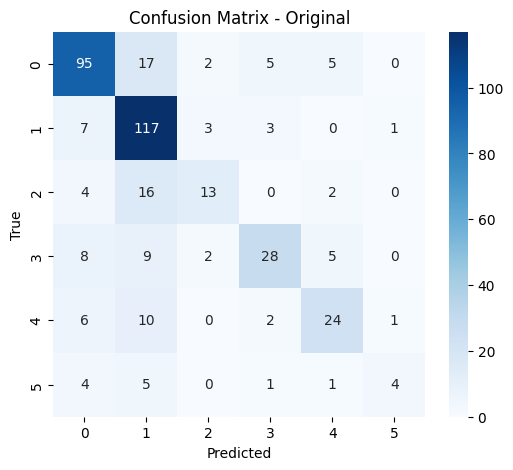

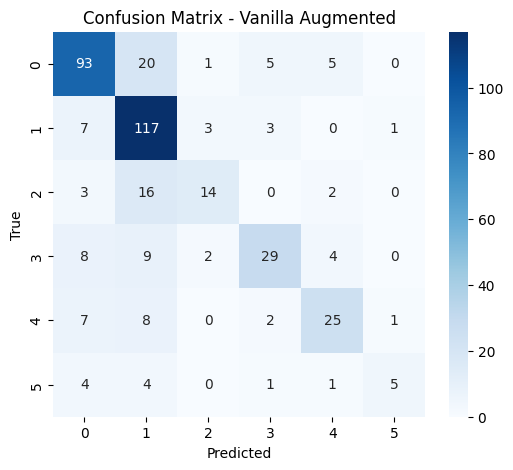

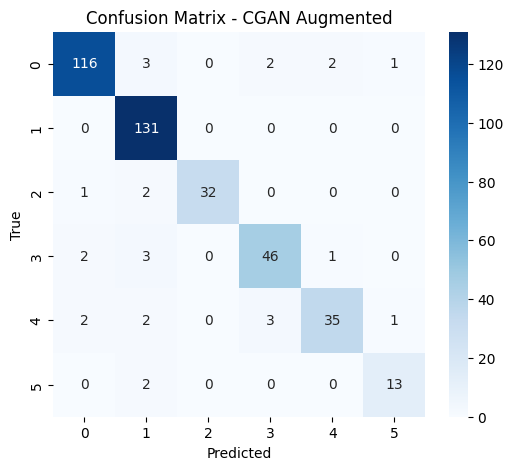

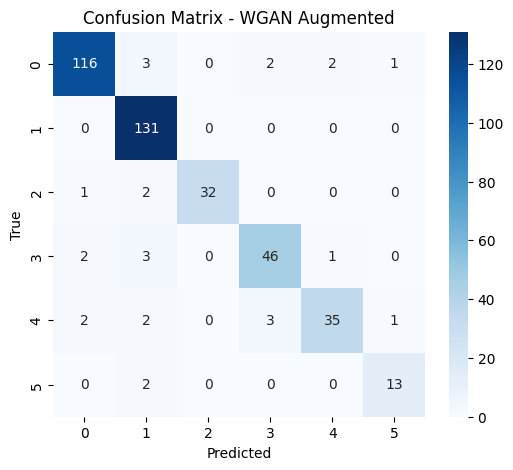

In [ ]:
#confusion matrix
def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# Predictions
clf_orig = MLPClassifier(hidden_layer_sizes=(64,32), max_iter=500, random_state=42)
clf_orig.fit(X_train, y_train)
y_pred_orig = clf_orig.predict(X_test)

clf_vanilla = MLPClassifier(hidden_layer_sizes=(64,32), max_iter=500, random_state=42)
clf_vanilla.fit(X_train_vanilla, y_train_vanilla)
y_pred_vanilla = clf_vanilla.predict(X_test)

clf_cgan = MLPClassifier(hidden_layer_sizes=(64,32), max_iter=500, random_state=42)
clf_cgan.fit(X_train_cgan, y_train_cgan)
y_pred_cgan = clf_cgan.predict(X_test)

clf_wgan = MLPClassifier(hidden_layer_sizes=(64,32), max_iter=500, random_state=42)
clf_wgan.fit(X_train_wgan, y_train_wgan)
y_pred_wgan = clf_wgan.predict(X_test)

# Plot
plot_cm(y_test, y_pred_orig, "Confusion Matrix - Original")
plot_cm(y_test, y_pred_vanilla, "Confusion Matrix - Vanilla Augmented")
plot_cm(y_test, y_pred_cgan, "Confusion Matrix - CGAN Augmented")
plot_cm(y_test, y_pred_wgan, "Confusion Matrix - WGAN Augmented")


=== Imbalanced Dataset ===
              precision    recall  f1-score   support

           0       0.66      0.73      0.70       116
           1       0.68      0.75      0.71       139
           2       0.48      0.38      0.42        32
           3       0.54      0.60      0.57        55
           4       0.68      0.47      0.55        45
           5       0.50      0.08      0.13        13

    accuracy                           0.64       400
   macro avg       0.59      0.50      0.51       400
weighted avg       0.63      0.64      0.63       400



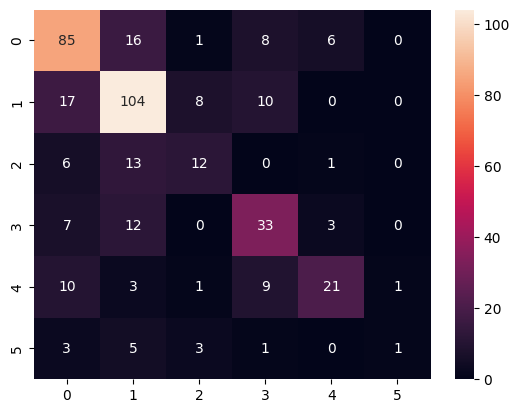

=== Vanilla GAN Balanced ===
              precision    recall  f1-score   support

           0       0.71      0.77      0.74       116
           1       0.68      0.82      0.75       139
           2       0.48      0.31      0.38        32
           3       0.62      0.55      0.58        55
           4       0.70      0.58      0.63        45
           5       1.00      0.08      0.14        13

    accuracy                           0.68       400
   macro avg       0.70      0.52      0.54       400
weighted avg       0.68      0.68      0.66       400



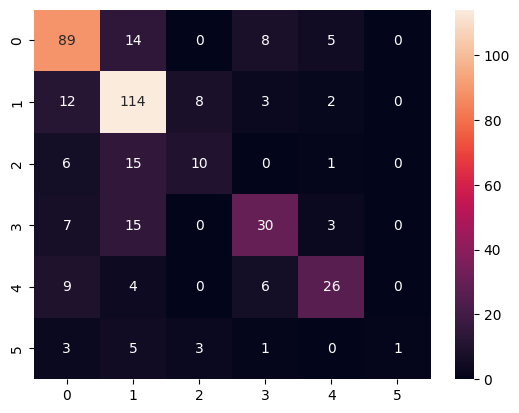

=== CGAN Balanced ===
              precision    recall  f1-score   support

           0       0.69      0.75      0.72       116
           1       0.68      0.80      0.73       139
           2       0.50      0.28      0.36        32
           3       0.58      0.56      0.57        55
           4       0.68      0.56      0.61        45
           5       0.50      0.08      0.13        13

    accuracy                           0.66       400
   macro avg       0.60      0.50      0.52       400
weighted avg       0.65      0.66      0.64       400



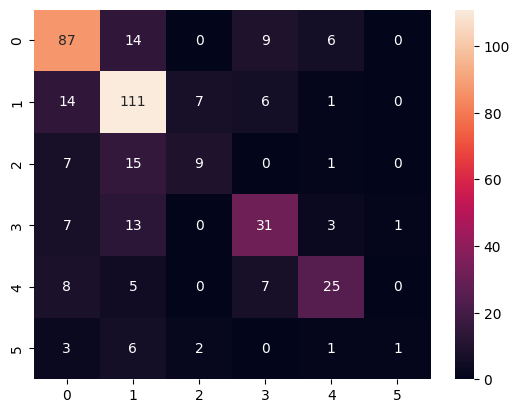

=== WGAN Balanced Dataset ===
              precision    recall  f1-score   support

           0       0.72      0.78      0.75       116
           1       0.72      0.83      0.77       139
           2       0.46      0.38      0.41        32
           3       0.61      0.56      0.58        55
           4       0.69      0.49      0.57        45
           5       0.60      0.23      0.33        13

    accuracy                           0.69       400
   macro avg       0.63      0.55      0.57       400
weighted avg       0.68      0.69      0.67       400



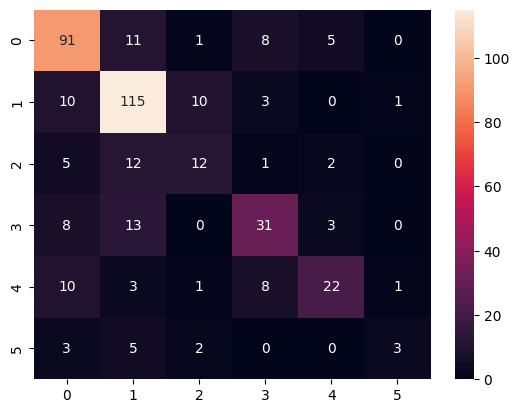

In [ ]:
#PyTorch Classifier
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        return self.net(x)

def train_eval(Xtr, ytr):
    model = Classifier().to(device)
    opt = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.CrossEntropyLoss()

    Xtr = torch.tensor(Xtr, dtype=torch.float32).to(device)
    ytr = torch.tensor(ytr, dtype=torch.long).to(device)

    for _ in range(200):
        loss = loss_fn(model(Xtr), ytr)
        opt.zero_grad(); loss.backward(); opt.step()

    with torch.no_grad():
        preds = model(torch.tensor(X_test, dtype=torch.float32).to(device)).argmax(1).cpu()
    print(classification_report(y_test, preds))
    sns.heatmap(confusion_matrix(y_test, preds), annot=True, fmt="d")
    plt.show()

print("=== Imbalanced Dataset ===")
train_eval(X_train, y_train)

print("=== Vanilla GAN Balanced ===")
train_eval(X_train_vanilla, y_train_vanilla)

print("=== CGAN Balanced ===")
train_eval(X_train_cgan, y_train_cgan)

print("=== WGAN Balanced Dataset ===")
train_eval(X_train_wgan, y_train_wgan)


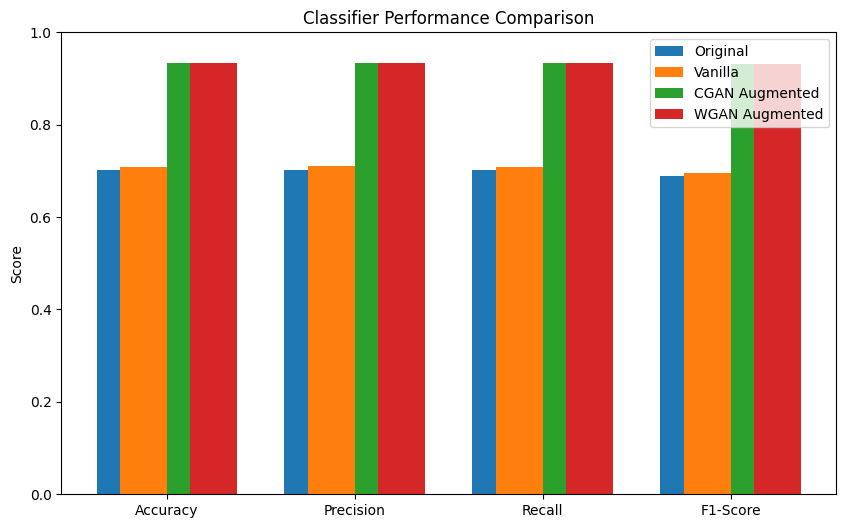

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

# Function to compute metrics
def compute_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    return acc, prec, rec, f1

# Train classifiers and get predictions
def get_metrics(X_train, y_train, X_test, y_test):
    clf = MLPClassifier(hidden_layer_sizes=(64,32), max_iter=500, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return compute_metrics(y_test, y_pred)

# Original
metrics_orig = get_metrics(X_train, y_train, X_test, y_test)

#vanilla
metrics_vanilla = get_metrics(X_train_vanilla, y_train_vanilla, X_test, y_test)

# CGAN
metrics_cgan = get_metrics(X_train_cgan, y_train_cgan, X_test, y_test)

# WGAN
metrics_wgan = get_metrics(X_train_wgan, y_train_wgan, X_test, y_test)

# Combine for plotting
metrics_names = ["Accuracy", "Precision", "Recall", "F1-Score"]
metrics_values = np.array([metrics_orig, metrics_vanilla, metrics_cgan, metrics_wgan])

# Plot comparison
x = np.arange(len(metrics_names))
width = 0.25

plt.figure(figsize=(10,6))
plt.bar(x - width, metrics_values[0], width, label='Original')
plt.bar(x- (width/2), metrics_values[1], width, label='Vanilla')
plt.bar(x+ (width/2), metrics_values[2], width, label='CGAN Augmented')
plt.bar(x + width, metrics_values[3], width, label='WGAN Augmented')

plt.ylabel("Score")
plt.ylim(0,1)
plt.xticks(x, metrics_names)
plt.title("Classifier Performance Comparison")
plt.legend()
plt.show()
